In [1]:
import tqdm
import numpy as np
import pandas as pd
import torch
import json
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import defaultdict
from transformers import BertTokenizer, EncoderDecoderModel, AutoModelForSequenceClassification

from readers import tg_reader, lenta_reader, ria_reader
from custom_datasets.agency_title_dataset import AgencyTitleDatasetGeneration
from custom_datasets import FullStyleDataset

def first_sent(x, token_id):
    lx = list(x)
    if token_id in x:
        return x[:lx.index(token_id)]
    return x

def reader(path):
    with open(path, 'r') as f:
        for line in f:
            yield json.loads(line.strip())

In [2]:
device = 'cuda'
# device = 'cpu'

In [3]:
tokenizer_path = '/home/aobuhtijarov/models/rubert_cased_L-12_H-768_A-12_pt/'

# BASELINES
joint_baseline_path = '/home/aobuhtijarov/models/joint-baseline/checkpoint-6000/'
ria_baseline_path = '/home/aobuhtijarov/models/ria_baseline/checkpoint-6000/'
lenta_baseline_path = '/home/aobuhtijarov/models/lenta_baseline/checkpoint-6000/'


# STYLE MODELS
joint_style_path = '/home/aobuhtijarov/models/full_style_model/checkpoint-6000/'
ria_style_path = '/home/aobuhtijarov/models/ria_style/checkpoint-6000/'
lenta_style_path = '/home/aobuhtijarov/models/lenta_style/checkpoint-6000/'


# DISCRIMINATOR
## HERE WE USE BEST
discr_model_path = '/home/aobuhtijarov/models/discriminator_on_clusters_from_rubert/'

In [4]:
tokenizer = BertTokenizer.from_pretrained(tokenizer_path, do_lower_case=False, do_basic_tokenize=False)

In [5]:
records = [r for r in tqdm.tqdm(reader('../../datasets/full_lenta_ria.test.jsonl'))]

lenta_records = [
    {'text': r['lenta_text'], 'title': r['lenta_title'], 'agency': 'lenta.ru', 'date': r['lenta_date']} 
    for r in records
]

ria_records = [
    {'text': r['ria_text'], 'title': r['ria_title'], 'agency': 'РИА Новости', 'date': r['lenta_date']} 
    for r in records
]

2000it [00:00, 2390.68it/s]


In [6]:
def text_to_transformer_input(text):
    inputs = tokenizer(
        text,
        add_special_tokens=True,
        max_length=250,
        padding="max_length",
        truncation=True
    )
    
    return {
        'input_ids': torch.LongTensor(inputs['input_ids']).to(device).unsqueeze(0),
        'attention_mask': torch.LongTensor(inputs['attention_mask']).to(device).unsqueeze(0)
    }

def text_to_transformer_input_not_unsqueeze(text):
    inputs = tokenizer(
        text,
        add_special_tokens=True,
        max_length=250,
        padding="max_length",
        truncation=True
    )
    
    return {
        'input_ids': torch.LongTensor(inputs['input_ids']).to(device),
        'attention_mask': torch.LongTensor(inputs['attention_mask']).to(device)
    }

def unsq(x):
    return {
        'input_ids': x['input_ids'].unsqueeze(0),
        'attention_mask': x['attention_mask'].unsqueeze(0),        
    }

In [7]:
generation_args = {
    'decoder_start_token_id': 0,
    'min_length': 7,
    'max_length': 20,
    'num_beams': 6
}

single_lenta_from_ria = []
single_lenta_from_lenta = []
single_ria_from_ria = []
single_ria_from_lenta = []

joint_lenta_from_ria = []
joint_lenta_from_lenta = []
joint_ria_from_ria = []
joint_ria_from_lenta = []

ref_ria = [r['ria_title'] for r in records]
ref_lenta = [r['lenta_title'] for r in records]

In [8]:
agency_list = ['РИА Новости', 'lenta.ru']
agency_to_special_token_id = {a: tokenizer.vocab[f'[unused{i+1}]'] for i, a in enumerate(agency_list)}
agency_to_discr_target = {a: i for i, a in enumerate(sorted(agency_list))}

In [9]:
def set_target_title(tok_otpt, agency_to_special_token_id, target_agency):
    marker = agency_to_special_token_id[target_agency]

    tok_otpt['input_ids'][2:] = tok_otpt['input_ids'][1:-1].clone()
    tok_otpt['input_ids'][1] = marker

    tok_otpt['attention_mask'][2:] = tok_otpt['attention_mask'][1:-1].clone()
    tok_otpt['attention_mask'][1] = 1

    return tok_otpt

In [ ]:
joint_style = EncoderDecoderModel.from_pretrained(joint_style_path)
joint_style.eval()
joint_style.to(device)

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        
        joint_lenta_from_ria.append(joint_style.generate(**unsq(
            set_target_title(text_to_transformer_input_not_unsqueeze(records[i]['ria_text']), 
                             agency_to_special_token_id, 'lenta.ru')
        ),
        **generation_args))
        
        joint_lenta_from_lenta.append(joint_style.generate(**unsq(
            set_target_title(text_to_transformer_input_not_unsqueeze(records[i]['lenta_text']), 
                             agency_to_special_token_id, 'lenta.ru')
        ),
        **generation_args))
        
        
        joint_ria_from_ria.append(joint_style.generate(**unsq(
            set_target_title(text_to_transformer_input_not_unsqueeze(records[i]['ria_text']), 
                             agency_to_special_token_id, 'РИА Новости')
        ),
        **generation_args))
        
        joint_ria_from_lenta.append(joint_style.generate(**unsq(
            set_target_title(text_to_transformer_input_not_unsqueeze(records[i]['lenta_text']), 
                             agency_to_special_token_id, 'РИА Новости')
        ),
        **generation_args))
        
joint_style.cpu();

 21%|██        | 424/2000 [13:43<1:28:26,  3.37s/it]

In [ ]:
ria_style = EncoderDecoderModel.from_pretrained(ria_style_path)
ria_style.eval()
ria_style.to(device)

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        ria_inp = text_to_transformer_input(records[i]['ria_text'])
        lenta_inp = text_to_transformer_input(records[i]['lenta_text'])
        
        single_ria_from_ria.append(
            ria_style.generate(**ria_inp, **generation_args)
        )
        
        single_ria_from_lenta.append(
            ria_style.generate(**lenta_inp, **generation_args)
        )
        
ria_style.cpu();

In [ ]:
lenta_style = EncoderDecoderModel.from_pretrained(lenta_style_path)
lenta_style.eval()
lenta_style.to(device)

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        ria_inp = text_to_transformer_input(records[i]['ria_text'])
        lenta_inp = text_to_transformer_input(records[i]['lenta_text'])
        
        single_lenta_from_ria.append(
            lenta_style.generate(**ria_inp, **generation_args)
        )
        
        single_lenta_from_lenta.append(
            lenta_style.generate(**lenta_inp, **generation_args)
        )
        
lenta_style.cpu();

In [ ]:
def trans_otpt_to_headline(otpt):
    return [
        tokenizer.decode(first_sent(x, tokenizer.sep_token_id), skip_special_tokens=True) for x in otpt
    ][0]

In [ ]:
%%time

single_ria_from_ria = [trans_otpt_to_headline(x) for x in single_ria_from_ria]
single_ria_from_lenta = [trans_otpt_to_headline(x) for x in single_ria_from_lenta]
single_lenta_from_ria = [trans_otpt_to_headline(x) for x in single_lenta_from_ria]
single_lenta_from_lenta = [trans_otpt_to_headline(x) for x in single_lenta_from_lenta]

joint_ria_from_ria = [trans_otpt_to_headline(x) for x in joint_ria_from_ria]
joint_ria_from_lenta = [trans_otpt_to_headline(x) for x in joint_ria_from_lenta]
joint_lenta_from_ria = [trans_otpt_to_headline(x) for x in joint_lenta_from_ria]
joint_lenta_from_lenta = [trans_otpt_to_headline(x) for x in joint_lenta_from_lenta]

## Style Metrics Table

In [23]:
import pandas as pd
import numpy as np

from utils.gen_title_calculate_metrics import calc_metrics

def scalar_from_metrics(m):
    return (m['rl'] + m['r2'] + m['rl']) / 3

### For joint

In [29]:
joint_results = np.zeros((6, 6))

headlines = (
    joint_lenta_from_ria, joint_lenta_from_lenta, ref_lenta, joint_ria_from_ria, joint_ria_from_lenta, ref_ria
)

names = (
    'RIA to Lenta', 'Lenta to Lenta', 'Ref Lenta', 'RIA to RIA', 'Lenta to RIA',  'Ref RIA'
)

for i, h1 in tqdm.tqdm(enumerate(headlines)):
    for j, h2 in enumerate(headlines):
        if type(h1[0]) != list:
            h1 = [[x] for x in h1]
        if type(h2[0]) != str:
            h2 = [x[0] for x in h2]
        
        joint_results[i, j] = scalar_from_metrics(
            calc_metrics(h1, h2, language='ru')
        )

6it [01:38, 16.41s/it]


In [30]:
df = pd.DataFrame(joint_results, columns=names, index=names).round(2)
df

,RIA to Lenta,Lenta to Lenta,Ref Lenta,RIA to RIA,Lenta to RIA,Ref RIA
RIA to Lenta,1.00,0.38,0.27,0.42,0.28,0.27
Lenta to Lenta,0.38,1.00,0.33,0.29,0.45,0.24
Ref Lenta,0.27,0.33,1.00,0.23,0.26,0.27
RIA to RIA,0.42,0.29,0.23,1.00,0.37,0.35
Lenta to RIA,0.28,0.45,0.26,0.37,1.00,0.27
Ref RIA,0.27,0.24,0.27,0.35,0.27,1.00


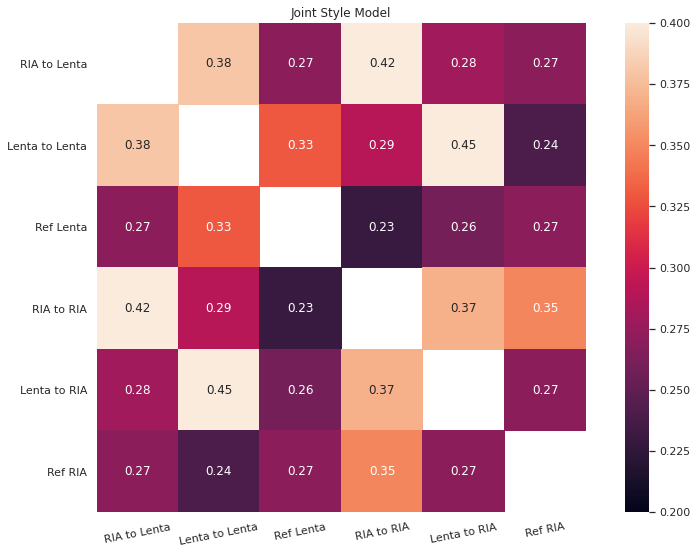

In [31]:
mask = np.zeros((6, 6), dtype=bool)
mask[np.diag_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 9))
    ax = sns.heatmap(df, mask=mask, vmax=.4, vmin=0.2, square=True, annot=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=11)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title('Joint Style Model')
    f.savefig('joint_style_eval.eps', bbox_inches='tight', format='eps')

### For single

In [32]:
single_results = np.zeros((6, 6))

headlines = (
    single_lenta_from_ria, single_lenta_from_lenta, ref_lenta, single_ria_from_ria, single_ria_from_lenta, ref_ria
)

names = (
    'RIA to Lenta', 'Lenta to Lenta', 'Ref Lenta', 'RIA to RIA', 'Lenta to RIA',  'Ref RIA'
)

for i, h1 in tqdm.tqdm(enumerate(headlines)):
    for j, h2 in enumerate(headlines):
        if type(h1[0]) != list:
            h1 = [[x] for x in h1]
        if type(h2[0]) != str:
            h2 = [x[0] for x in h2]
        
        single_results[i, j] = scalar_from_metrics(
            calc_metrics(h1, h2, language='ru')
        )

6it [01:34, 15.74s/it]


In [33]:
df = pd.DataFrame(single_results, columns=names, index=names).round(2)
df

,RIA to Lenta,Lenta to Lenta,Ref Lenta,RIA to RIA,Lenta to RIA,Ref RIA
RIA to Lenta,1.00,0.37,0.25,0.28,0.22,0.23
Lenta to Lenta,0.37,1.00,0.30,0.22,0.28,0.21
Ref Lenta,0.25,0.30,1.00,0.22,0.24,0.27
RIA to RIA,0.28,0.22,0.22,1.00,0.36,0.32
Lenta to RIA,0.22,0.28,0.24,0.36,1.00,0.26
Ref RIA,0.23,0.21,0.27,0.32,0.26,1.00


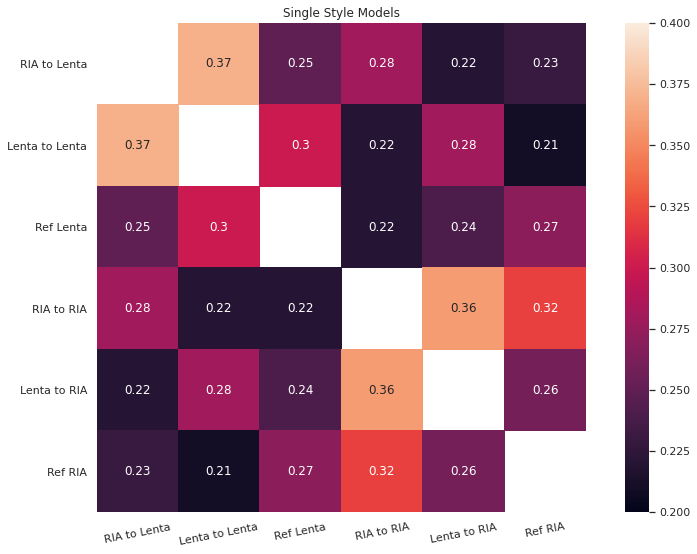

In [34]:
mask = np.zeros((6, 6), dtype=bool)
mask[np.diag_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 9))
    ax = sns.heatmap(df, mask=mask, vmax=.4, vmin=0.2, square=True, annot=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=11)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 
    ax.set_title('Single Style Models')
    f.savefig('single_style_eval.eps', bbox_inches='tight', format='eps')    

## Style Discriminator eval

In [45]:
def get_discr_res(ria_zag, lenta_zag, mode='SOFT'):
    # Vanilla discriminator
    
    inputs_ria = tokenizer(
        ria_zag,
        add_special_tokens=True,
        max_length=48,
        padding="max_length",
        truncation=True
    )

    inputs_lenta = tokenizer(
        lenta_zag,
        add_special_tokens=True,
        max_length=48,
        padding="max_length",
        truncation=True
    )

    logits_ria = discriminator(input_ids=torch.LongTensor(inputs_ria['input_ids']).to(device).unsqueeze(0), 
                           attention_mask=torch.LongTensor(inputs_ria['attention_mask']).to(device).unsqueeze(0))[0][0]
    pred_ria = torch.argmax(logits_ria).item()

    logits_lenta = discriminator(input_ids=torch.LongTensor(inputs_lenta['input_ids']).to(device).unsqueeze(0), 
                           attention_mask=torch.LongTensor(inputs_lenta['attention_mask']).to(device).unsqueeze(0))[0][0]
    pred_lenta = torch.argmax(logits_lenta).item()

    if mode == 'HARD':
        return int(pred_ria == agency_to_discr_target['РИА Новости'] and \
                       pred_lenta == agency_to_discr_target['lenta.ru'])
    elif mode == 'SOFT':
        return int(logits_ria[agency_to_discr_target['lenta.ru']] < \
                       logits_lenta[agency_to_discr_target['lenta.ru']])
    assert False

In [50]:
discriminator = AutoModelForSequenceClassification.from_pretrained(discr_model_path)
discriminator.eval()
discriminator.to(device)

results = {
    'single': {
        'from ria': 0,
        'from lenta': 0,
        'both cross': 0,
        'both direct': 0,
    },
    'joint': {
        'from ria': 0,
        'from lenta': 0,
        'both cross': 0,
        'both direct': 0,
    }
}

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        # Single
        ria_zag_from_lenta = single_ria_from_lenta[i]
        ria_zag_from_ria = single_ria_from_ria[i]

        lenta_zag_from_ria = single_lenta_from_ria[i]
        lenta_zag_from_lenta = single_lenta_from_lenta[i]

        results['single']['from ria'] += get_discr_res(ria_zag_from_ria, lenta_zag_from_ria)
        results['single']['from lenta'] += get_discr_res(ria_zag_from_lenta, lenta_zag_from_lenta)
        results['single']['both cross'] += get_discr_res(ria_zag_from_lenta, lenta_zag_from_ria)
        results['single']['both direct'] += get_discr_res(ria_zag_from_ria, lenta_zag_from_lenta)
    
        # Joint
        ria_zag_from_lenta = joint_ria_from_lenta[i]
        ria_zag_from_ria = joint_ria_from_ria[i]

        lenta_zag_from_ria = joint_lenta_from_ria[i]
        lenta_zag_from_lenta = joint_lenta_from_lenta[i]

        results['joint']['from ria'] += get_discr_res(ria_zag_from_ria, lenta_zag_from_ria)
        results['joint']['from lenta'] += get_discr_res(ria_zag_from_lenta, lenta_zag_from_lenta)
        results['joint']['both cross'] += get_discr_res(ria_zag_from_lenta, lenta_zag_from_ria)
        results['joint']['both direct'] += get_discr_res(ria_zag_from_ria, lenta_zag_from_lenta)
    
discriminator.cpu();

100%|██████████| 2000/2000 [08:03<00:00,  4.14it/s]


In [69]:
disc_df = pd.DataFrame(results)
plot_df = pd.DataFrame({
    'Count': list(disc_df['single']) + list(disc_df['joint']),
    'Model': ['Single'] * 4 + ['Joint'] * 4,
    'Mode': ['From RIA', 'From Lenta', 'Both cross', 'Both direct'] * 2,
})
plot_df['Count'] /= 2000

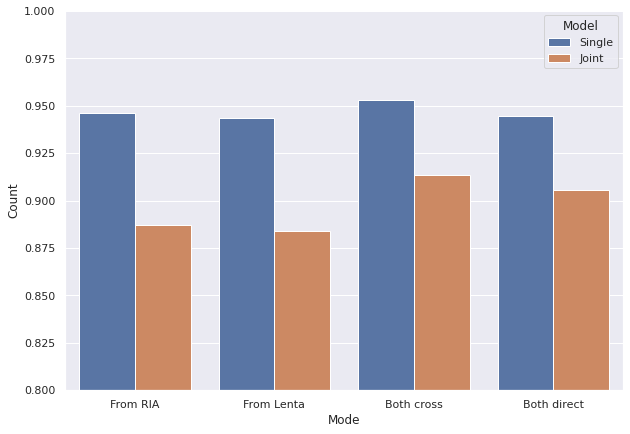

In [71]:
plt.figure(figsize=(10, 7))
sns.barplot(x='Mode', y='Count', hue='Model', data=plot_df)
plt.ylim(0.8)
plt.show()

## Gen Title eval

In [78]:
joint_baseline_hyps_ria = []
joint_baseline_hyps_lenta = []

single_baseline_hyps_ria = []
single_baseline_hyps_lenta = []

In [79]:
joint_baseline = EncoderDecoderModel.from_pretrained(joint_baseline_path)
joint_baseline.eval()
joint_baseline.to(device)

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        ria_inp = text_to_transformer_input(records[i]['ria_text'])
        lenta_inp = text_to_transformer_input(records[i]['lenta_text'])
        
        joint_baseline_hyps_ria.append(
            joint_baseline.generate(**ria_inp, **generation_args)
        )
        
        joint_baseline_hyps_lenta.append(
            joint_baseline.generate(**lenta_inp, **generation_args)
        )

joint_baseline.cpu();

100%|██████████| 2000/2000 [42:15<00:00,  1.27s/it]


In [80]:
ria_baseline = EncoderDecoderModel.from_pretrained(ria_baseline_path)
ria_baseline.eval()
ria_baseline.to(device)

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        ria_inp = text_to_transformer_input(records[i]['ria_text'])
        
        single_baseline_hyps_ria.append(
            ria_baseline.generate(**ria_inp, **generation_args)
        )

ria_baseline.cpu();

100%|██████████| 2000/2000 [21:37<00:00,  1.54it/s]


In [81]:
lenta_baseline = EncoderDecoderModel.from_pretrained(lenta_baseline_path)
lenta_baseline.eval()
lenta_baseline.to(device)

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        lenta_inp = text_to_transformer_input(records[i]['lenta_text'])
        
        single_baseline_hyps_lenta.append(
            lenta_baseline.generate(**lenta_inp, **generation_args)
        )

lenta_baseline.cpu();

100%|██████████| 2000/2000 [12:00<00:00,  2.77it/s]


In [82]:
if type(ref_ria[0]) != list:
    ref_ria = [[x] for x in ref_ria]
if type(ref_lenta[0]) != list:
    ref_lenta = [[x] for x in ref_lenta]

In [83]:
%%time

joint_baseline_hyps_ria = [trans_otpt_to_headline(x) for x in joint_baseline_hyps_ria]
joint_baseline_hyps_lenta = [trans_otpt_to_headline(x) for x in joint_baseline_hyps_lenta]

single_baseline_hyps_ria = [trans_otpt_to_headline(x) for x in single_baseline_hyps_ria]
single_baseline_hyps_lenta = [trans_otpt_to_headline(x) for x in single_baseline_hyps_lenta]

CPU times: user 5.7 s, sys: 35.6 ms, total: 5.73 s
Wall time: 5.73 s


In [84]:
def metrics_extract(metrics):
    return {
        'BLEU': metrics['bleu'],
        'Rouge-1': metrics['r1'],
        'Rouge-2': metrics['r2'],
        'Rouge-L': metrics['rl'],
        'Rouge-Mean': (metrics['r1'] + metrics['r2'] + metrics['rl']) / 3,
    }

### Joint hyps With Joint baseline

In [85]:
ria_baseline_metrics = calc_metrics(ref_ria, joint_baseline_hyps_ria, language='ru')
lenta_baseline_metrics = calc_metrics(ref_lenta, joint_baseline_hyps_lenta, language='ru')

ria_style_cross_metrics = calc_metrics(ref_ria, joint_ria_from_lenta, language='ru')
ria_style_direct_metrics = calc_metrics(ref_ria, joint_ria_from_ria, language='ru')

lenta_style_cross_metrics = calc_metrics(ref_lenta, joint_lenta_from_ria, language='ru')
lenta_style_direct_metrics = calc_metrics(ref_lenta, joint_lenta_from_lenta, language='ru')

In [86]:
df = pd.DataFrame(metrics_extract(ria_baseline_metrics), index=['RIA Baseline']).append(
    pd.DataFrame(metrics_extract(lenta_baseline_metrics), index=['Lenta Baseline'])).append(
    pd.DataFrame(metrics_extract(ria_style_cross_metrics), index=['RIA cross'])).append(
    pd.DataFrame(metrics_extract(ria_style_direct_metrics), index=['RIA direct'])).append(
    pd.DataFrame(metrics_extract(ria_style_cross_metrics), index=['Lenta direct'])).append(
    pd.DataFrame(metrics_extract(ria_style_direct_metrics), index=['Lenta direct'])).round(2)

In [87]:
df

,BLEU,Rouge-1,Rouge-2,Rouge-L,Rouge-Mean
RIA Baseline,0.54,0.43,0.24,0.41,0.36
Lenta Baseline,0.53,0.41,0.22,0.39,0.34
RIA cross,0.48,0.34,0.16,0.33,0.28
RIA direct,0.55,0.43,0.24,0.41,0.36
Lenta direct,0.48,0.34,0.16,0.33,0.28
Lenta direct,0.55,0.43,0.24,0.41,0.36


### With single baseline

In [88]:
ria_baseline_metrics = calc_metrics(ref_ria, single_baseline_hyps_ria, language='ru')
lenta_baseline_metrics = calc_metrics(ref_lenta, single_baseline_hyps_lenta, language='ru')

ria_style_cross_metrics = calc_metrics(ref_ria, single_ria_from_lenta, language='ru')
ria_style_direct_metrics = calc_metrics(ref_ria, single_ria_from_ria, language='ru')

lenta_style_cross_metrics = calc_metrics(ref_lenta, single_lenta_from_ria, language='ru')
lenta_style_direct_metrics = calc_metrics(ref_lenta, single_lenta_from_lenta, language='ru')

In [89]:
df = pd.DataFrame(metrics_extract(ria_baseline_metrics), index=['RIA Baseline']).append(
    pd.DataFrame(metrics_extract(lenta_baseline_metrics), index=['Lenta Baseline'])).append(
    pd.DataFrame(metrics_extract(ria_style_cross_metrics), index=['RIA cross'])).append(
    pd.DataFrame(metrics_extract(ria_style_direct_metrics), index=['RIA direct'])).append(
    pd.DataFrame(metrics_extract(ria_style_cross_metrics), index=['Lenta direct'])).append(
    pd.DataFrame(metrics_extract(ria_style_direct_metrics), index=['Lenta direct'])).round(2)

In [90]:
df

,BLEU,Rouge-1,Rouge-2,Rouge-L,Rouge-Mean
RIA Baseline,0.54,0.42,0.23,0.40,0.35
Lenta Baseline,0.50,0.38,0.20,0.36,0.31
RIA cross,0.45,0.33,0.15,0.31,0.26
RIA direct,0.51,0.39,0.21,0.38,0.33
Lenta direct,0.45,0.33,0.15,0.31,0.26
Lenta direct,0.51,0.39,0.21,0.38,0.33


## Dumping headlines

In [112]:
from utils.gen_title_calculate_metrics import postprocess

In [126]:
discriminator.to(device);

In [132]:
ok_cnt = 0

with open('on_ria.txt', 'w') as f:
    for i in tqdm.trange(len(records)):
        ria_zag = ria_from_ria[i]
        lenta_zag = lenta_from_ria[i]
        
        ria_ref_zag = ref_ria[i]
        lenta_ref_zag = ref_lenta[i]        
            
        inp_ria = tokenizer(ria_zag, 
            add_special_tokens=True, max_length=48,
            padding='max_length', truncation=True
        )
        inp_lenta = tokenizer(lenta_zag, 
            add_special_tokens=True, max_length=48,
            padding='max_length', truncation=True
        )
        
        logits_ria = discriminator(input_ids=torch.LongTensor(inp_ria['input_ids']).cuda().unsqueeze(0), 
                           attention_mask=torch.LongTensor(inp_ria['attention_mask']).cuda().unsqueeze(0))[0]
        logits_lenta = discriminator(input_ids=torch.LongTensor(inp_lenta['input_ids']).cuda().unsqueeze(0), 
                           attention_mask=torch.LongTensor(inp_lenta['attention_mask']).cuda().unsqueeze(0))[0]            
        ria_pred = torch.argmax(logits_ria).item()
        lenta_pred = torch.argmax(logits_lenta).item()

        if not (ria_pred != lenta_pred and \
                ria_pred == agency_to_discr_target['РИА Новости'] and \
                min(logits_ria.max().item(), logits_lenta.max().item()) >= 4.57):
            continue

        ria_ref_zag, ria_zag = postprocess(ria_ref_zag, ria_zag, 'ru', is_multiple_ref=True, lower=True)
        lenta_ref_zag, lenta_zag = postprocess(lenta_ref_zag, lenta_zag, 'ru', is_multiple_ref=True, lower=True)

        f.write('RIA text: ' + records[i]['ria_text'] + '\n\n')
        f.write('RIA Ref headline: ' + ria_ref_zag[0] + '\n')
        f.write('Lenta Ref headline: ' + lenta_ref_zag[0] + '\n\n')

        f.write('RIA Hyp headline: ' + ria_zag + '\n')
        f.write('Lenta Hyp headline: ' + lenta_zag + '\n')

        f.write('\n\n' + '-' * 50 + '\n')
        ok_cnt += 1
        
print(ok_cnt)

100%|██████████| 2000/2000 [00:34<00:00, 58.53it/s]

59


In [133]:
ok_cnt = 0

with open('on_lenta.txt', 'w') as f:
    for i in tqdm.trange(len(records)):
        ria_zag = ria_from_lenta[i]
        lenta_zag = lenta_from_lenta[i]
        
        ria_ref_zag = ref_ria[i]
        lenta_ref_zag = ref_lenta[i]      
            
        inp_ria = tokenizer(ria_zag, 
            add_special_tokens=True, max_length=48,
            padding='max_length', truncation=True
        )
        inp_lenta = tokenizer(lenta_zag, 
            add_special_tokens=True, max_length=48,
            padding='max_length', truncation=True
        )
        
        logits_ria = discriminator(input_ids=torch.LongTensor(inp_ria['input_ids']).cuda().unsqueeze(0), 
                           attention_mask=torch.LongTensor(inp_ria['attention_mask']).cuda().unsqueeze(0))[0]
        logits_lenta = discriminator(input_ids=torch.LongTensor(inp_lenta['input_ids']).cuda().unsqueeze(0), 
                           attention_mask=torch.LongTensor(inp_lenta['attention_mask']).cuda().unsqueeze(0))[0]            
        ria_pred = torch.argmax(logits_ria).item()
        lenta_pred = torch.argmax(logits_lenta).item()


        if not (ria_pred != lenta_pred and \
                ria_pred == agency_to_discr_target['РИА Новости'] and \
                min(logits_ria.max().item(), logits_lenta.max().item()) >= 4.57):
            continue

        ria_ref_zag, ria_zag = postprocess(ria_ref_zag, ria_zag, 'ru', is_multiple_ref=True, lower=True)
        lenta_ref_zag, lenta_zag = postprocess(lenta_ref_zag, lenta_zag, 'ru', is_multiple_ref=True, lower=True)

        f.write('Lenta text: ' + records[i]['lenta_text'] + '\n\n')
        f.write('RIA Ref headline: ' + ria_ref_zag[0] + '\n')
        f.write('Lenta Ref headline: ' + lenta_ref_zag[0] + '\n\n')

        f.write('RIA Hyp headline: ' + ria_zag + '\n')
        f.write('Lenta Hyp headline: ' + lenta_zag + '\n')

        f.write('\n\n' + '-' * 50 + '\n')
        
        ok_cnt += 1
        
print(ok_cnt)

100%|██████████| 2000/2000 [00:34<00:00, 58.59it/s]

51


In [134]:
discriminator.cpu();

## Watching clusters split

In [140]:
train =  [r for r in tqdm.tqdm(reader('../../datasets/full_lenta_ria.train.jsonl'))]
test = [r for r in tqdm.tqdm(reader('../../datasets/full_lenta_ria.test.jsonl'))]

75362it [00:16, 4526.69it/s]
2000it [00:00, 5875.15it/s]


In [141]:
from collections import Counter

train_texts = [r['ria_text'] for r in train] + [r['lenta_text'] for r in train]
test_texts = [r['ria_text'] for r in test] + [r['lenta_text'] for r in test]

In [142]:
trc = Counter()

for x in train_texts:
    trc.update(x.lower().split())

In [143]:
tc = Counter()

for x in test_texts:
    tc.update(x.lower().split())

In [144]:
trc.most_common(100)[50:]

[('тысяч', 39677),
 ('их', 39408),
 ('года.', 38561),
 ('однако', 37977),
 ('еще', 37619),
 ('сказал', 37316),
 ('данным', 37163),
 ('около', 36350),
 ('под', 35945),
 ('все', 35831),
 ('ее', 34080),
 ('была', 33369),
 ('они', 33155),
 ('сообщил', 31440),
 ('этого', 29242),
 ('словам', 28976),
 ('суд', 27961),
 ('может', 27937),
 ('сша', 27443),
 ('власти', 27228),
 ('или', 26893),
 ('только', 26851),
 ('будут', 26840),
 ('миллионов', 26790),
 ('несколько', 26315),
 ('ссылкой', 26178),
 ('заявил', 26130),
 ('результате', 26066),
 ('чтобы', 25832),
 ('кроме', 25810),
 ('2011', 25788),
 ('том,', 25465),
 ('один', 25234),
 ('пока', 25086),
 ('же', 25045),
 ('так', 24886),
 ('является', 24618),
 ('из-за', 24570),
 ('компании', 24411),
 ('2010', 24297),
 ('глава', 23955),
 ('2012', 23911),
 ('президент', 23905),
 ('где', 23747),
 ('против', 23458),
 ('решение', 22976),
 ('два', 22654),
 ('>>', 22631),
 ('говорится', 22322),
 ('между', 22255)]

In [145]:
tc.most_common(100)[50:]

[('мы', 965),
 ('сша', 932),
 ('украины', 927),
 ('глава', 915),
 ('было', 901),
 ('уже', 895),
 ('более', 887),
 ('их', 872),
 ('еще', 869),
 ('который', 866),
 ('тысяч', 864),
 ('все', 853),
 ('2015', 846),
 ('того,', 828),
 ('под', 791),
 ('они', 784),
 ('может', 768),
 ('около', 761),
 ('сообщил', 747),
 ('этого', 747),
 ('против', 723),
 ('из-за', 715),
 ('новости', 685),
 ('говорится', 684),
 ('ее', 682),
 ('была', 678),
 ('будут', 671),
 ('владимир', 666),
 ('власти', 663),
 ('чтобы', 661),
 ('или', 659),
 ('данным', 654),
 ('решение', 652),
 ('однако', 643),
 ('миллионов', 627),
 ('компании', 613),
 ('словам', 612),
 ('декабря,', 598),
 ('заявил,', 598),
 ('является', 597),
 ('только', 594),
 ('так', 587),
 ('словам,', 582),
 ('1', 565),
 ('она', 554),
 ('же', 553),
 ('быть', 545),
 ('связи', 544),
 ('том,', 541),
 ('10', 540)]